In [2]:
!pip install -q torch transformers accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl pacmap datasets langchain-community ragatouille

In [3]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)  # This will be helpful when visualizing retriever outputs

In [4]:
%pip install -qU pypdf

In [5]:
from langchain_community.document_loaders import PyPDFLoader

file_path = "/content/philospersStone-2-14.pdf"

loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [6]:
print(f"{pages[0].metadata}\n")
print(pages[0].page_content)

{'producer': 'iLovePDF', 'creator': 'PyPDF', 'creationdate': '', 'moddate': '2025-05-21T19:06:00+00:00', 'source': '/content/philospersStone-2-14.pdf', 'total_pages': 13, 'page': 0, 'page_label': '1'}

1
Harry Potter and the Sorcerer's Stone
CHAPTER ONE
THE BOY WHO LIVED
Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say
that they were perfectly normal, thank you very much. They were the last
people you'd expect to be involved in anything strange or mysterious,
because they just didn't hold with such nonsense.
Mr. Dursley was the director of a firm called Grunnings, which made
drills. He was a big, beefy man with hardly any neck, although he did
have a very large mustache. Mrs. Dursley was thin and blonde and had
nearly twice the usual amount of neck, which came in very useful as she
spent so much of her time craning over garden fences, spying on the
neighbors. The Dursleys had a small son called Dudley and in their
opinion there was no finer boy anywhere.
The Dursle

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for page in pages:
    docs_processed += text_splitter.split_documents([page])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Model's maximum sequence length: 512


  0%|          | 0/36 [00:00<?, ?it/s]

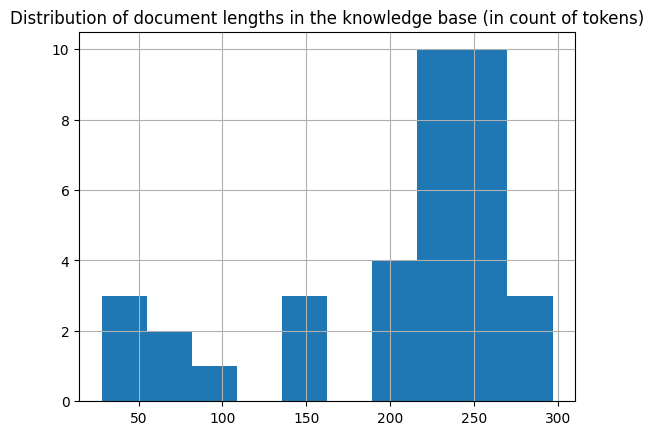

In [8]:
from sentence_transformers import SentenceTransformer

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}")

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

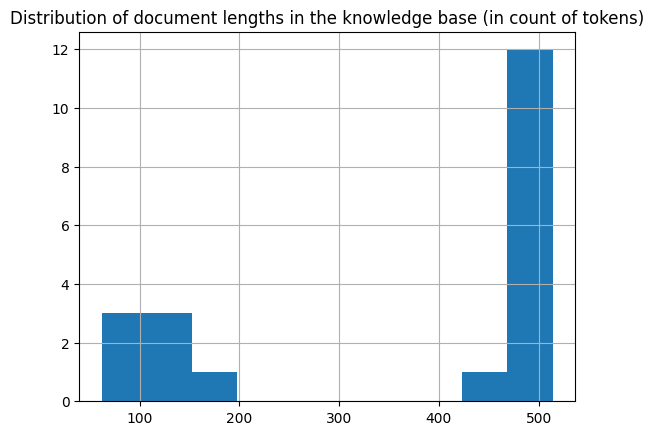

In [9]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer
from langchain_core.documents import Document as LangchainDocument


EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    pages,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [10]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=False,
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

<ipython-input-10-eb42e59844f8>:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


In [11]:
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import torch

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME,
    torch_dtype=torch.float32,  # Use float32 for CPU; or torch.float16 if you switch to GPU later
    device_map="auto"           # Will map to CPU if CUDA not available
)

tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Device set to use cpu


In [11]:
READER_LLM("What is 4+4? Answer:")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-f1a2be69ee9f>", line 1, in <cell line: 0>
    READER_LLM("What is 4+4? Answer:")
  File "/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_generation.py", line 287, in __call__
    return super().__call__(text_inputs, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/pipelines/base.py", line 1379, in __call__
    return self.run_single(inputs, preprocess_params, forward_params, postprocess_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/pipelines/base.py", line 1386, in run_single
    model_outputs = self.forward(model_inputs, **forward_params)
                    ^^^^^^^

TypeError: object of type 'NoneType' has no len()